# credit risk modelling

In [5]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import scorecardpy as sc #checking gini coefficient of the model 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
# pip install fancyimpute 
from fancyimpute import IterativeImputer #this package apply MICE imputation for missing value treatment
from sklearn.model_selection import train_test_split
import seaborn as sns

In [6]:
data=pd.read_csv('credit_risk_dataset.csv')

In [7]:
print(data.head())
data.describe()

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


As we can see the data contains 12 variables, 4 of them are categorical, rest o them are numerical; thhe target is loan status, and we will use only mortgage data as working dataset.  

#### subseting - only mortgage data wanted

In [8]:
df= data.loc[data['person_home_ownership']=='MORTGAGE', :].copy()

#### missing value treatment

In [9]:
print(df.isna().sum().sum())

1673


In [10]:
print(df.isna().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              351
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 1322
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


there are 1673 nan after subseting the dataset,majority of them are in the loan_int_rate variable, minority of them in person_emp_length.
Thus, we decide to use MICE method to fill nan. 

In [11]:
MICE_inputer=IterativeImputer()

In [12]:
df_MICE=df.copy(deep=True)

In [13]:
df_MICE.loc[:,['person_age','person_income','loan_amnt','loan_percent_income','cb_person_cred_hist_length','person_emp_length','loan_int_rate']]=MICE_inputer.fit_transform(df_MICE.loc[:,['person_age','person_income','loan_amnt','loan_percent_income','cb_person_cred_hist_length','person_emp_length','loan_int_rate']])

In [14]:
print(df_MICE.isna().sum())

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


after imputation, there are no nan in dataset.

#### outlier treatment

array([[<AxesSubplot:title={'center':'person_age'}>,
        <AxesSubplot:title={'center':'person_income'}>,
        <AxesSubplot:title={'center':'person_emp_length'}>],
       [<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'loan_int_rate'}>,
        <AxesSubplot:title={'center':'loan_status'}>],
       [<AxesSubplot:title={'center':'loan_percent_income'}>,
        <AxesSubplot:title={'center':'cb_person_cred_hist_length'}>,
        <AxesSubplot:>]], dtype=object)

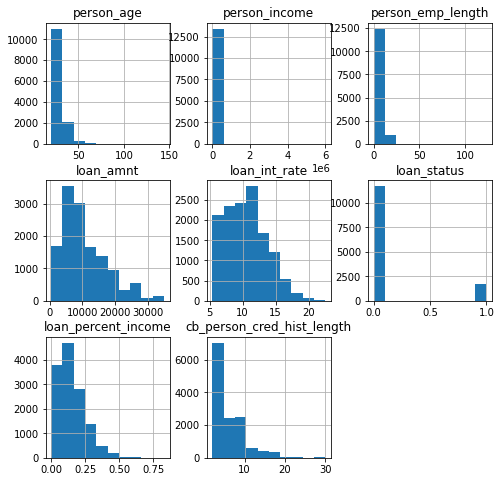

In [15]:
df_MICE.hist(figsize=(8,8))

as we can observed from the histgram there are some outlier in numerical variables, nevertheless, based on the real meaning we choose to replace some of them with 95% boundary value

In [16]:
print(df_MICE['person_income'].quantile(0.95))

160000.0


after checking the distribution of numerical variables we can observe that the outlier has significant impact on dataset, nevertheless the 95% quantile is too closr to central, thus we decide to use 99% quantile to replace outliers for selected features based on the real meaning.  

In [17]:
df_MICE['person_age']=np.where(df_MICE['person_age']>df_MICE['person_age'].quantile(0.99),df_MICE['person_age'].quantile(0.99),df_MICE['person_age'])
df_MICE['person_income']=np.where(df_MICE['person_income']>df_MICE['person_income'].quantile(0.99),df_MICE['person_income'].quantile(0.99),df_MICE['person_income'])
df_MICE['person_emp_length']=np.where(df_MICE['person_emp_length']>df_MICE['person_emp_length'].quantile(0.99),df_MICE['person_emp_length'].quantile(0.99),df_MICE['person_emp_length'])
df_MICE['loan_percent_income']=np.where(df_MICE['loan_percent_income']>df_MICE['loan_percent_income'].quantile(0.99),df_MICE['loan_percent_income'].quantile(0.99),df_MICE['loan_percent_income'])
df_MICE['cb_person_cred_hist_length']=np.where(df_MICE['cb_person_cred_hist_length']>df_MICE['cb_person_cred_hist_length'].quantile(0.99),df_MICE['cb_person_cred_hist_length'].quantile(0.99),df_MICE['cb_person_cred_hist_length'])


array([[<AxesSubplot:title={'center':'person_age'}>,
        <AxesSubplot:title={'center':'person_income'}>,
        <AxesSubplot:title={'center':'person_emp_length'}>],
       [<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'loan_int_rate'}>,
        <AxesSubplot:title={'center':'loan_status'}>],
       [<AxesSubplot:title={'center':'loan_percent_income'}>,
        <AxesSubplot:title={'center':'cb_person_cred_hist_length'}>,
        <AxesSubplot:>]], dtype=object)

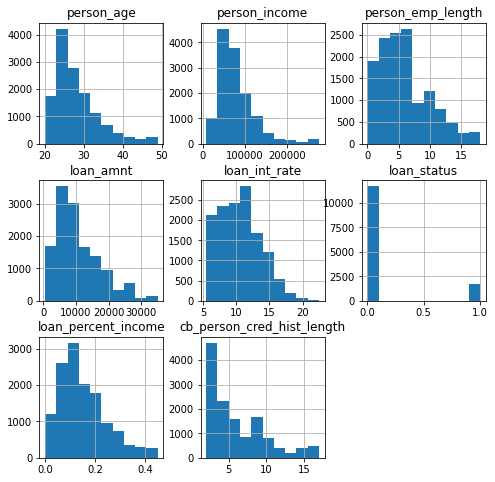

In [18]:
df_MICE.hist(figsize=(8,8))

afterw we removed some extreme outlers, the dataset distributed much make sense.

#### building model & split dataset

In [19]:
df_MICE.cb_person_default_on_file=df_MICE.cb_person_default_on_file.map(dict(Y=1, N=0))

In [20]:
cormat = df_MICE.corr()
round(cormat,4)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
person_age,1.0000,0.1539,0.2128,0.0569,0.0178,-0.0108,-0.0415,0.0117,0.8667
person_income,0.1539,1.0000,0.1019,0.3655,0.0722,-0.0955,-0.3437,0.0327,0.1321
person_emp_length,0.2128,0.1019,1.0000,0.0400,-0.0420,-0.0140,-0.0457,-0.0067,0.1883
loan_amnt,0.0569,0.3655,0.0400,1.0000,0.2311,0.0545,0.6326,0.0834,0.0448
loan_int_rate,0.0178,0.0722,-0.0420,0.2311,1.0000,0.3245,0.1509,0.4819,0.0154
loan_status,-0.0108,-0.0955,-0.0140,0.0545,0.3245,1.0000,0.1308,0.2029,-0.0151
loan_percent_income,-0.0415,-0.3437,-0.0457,0.6326,0.1509,0.1308,1.0000,0.0514,-0.0380
cb_person_default_on_file,0.0117,0.0327,-0.0067,0.0834,0.4819,0.2029,0.0514,1.0000,0.0105
cb_person_cred_hist_length,0.8667,0.1321,0.1883,0.0448,0.0154,-0.0151,-0.0380,0.0105,1.0000


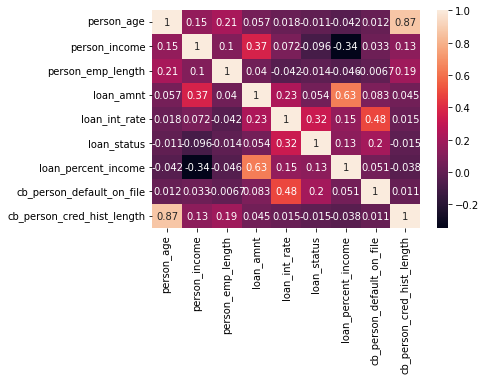

In [21]:
heat_map=sns.heatmap(cormat, annot=True)

According to heatmap we select person_age but not Hist length to use in our modeling, since they are highly corrrelated 

In [22]:
y=df_MICE['loan_status']
X=df_MICE.loc[:,['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_default_on_file',]]

In [23]:
predictors=['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_default_on_file',]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42, stratify=y)

In [25]:
lr=LogisticRegression()

#### Logistic regression

In [26]:
lr.fit(X_train,y_train)

LogisticRegression()

In [27]:
y_pred=lr.predict(X_test)

In [28]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [29]:
print(np.exp(lr.coef_))
print(predictors)
print(lr.intercept_)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[0.89126075 0.99998387 0.9825119  1.0000178  1.22650047 0.99861124
  1.02079418]]
['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file']
[-0.009114]
[[2331   20]
 [ 317   21]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2351
           1       0.51      0.06      0.11       338

    accuracy                           0.87      2689
   macro avg       0.70      0.53      0.52      2689
weighted avg       0.83      0.87      0.83      2689



accourding to the odds and coefficients we can say based on our model in crease in age will decrease the probability of default by 11%, it is also be noticed that increase in loan interest rate will casuse 22% more probalility of default.

In [30]:
accuracy_score(y_test, y_pred)
##lr.score(X_test,y_test)

0.8746746002231313

The accuracy based on our model is 87.46%. 

the logistic regression give us 87.46% accuracy 

#### ROC curve

In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [32]:
y_pred_prob = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [33]:
roc_auc = roc_auc_score(y_test, y_pred_prob)

method_1-ROC curve

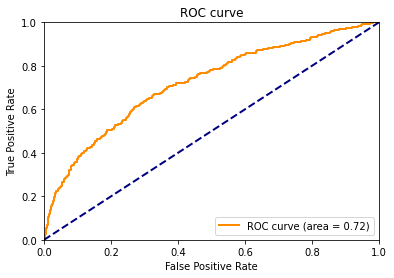

In [34]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

The performance of the model at distinguishing between the defaulted and not default is 0.72.

#### LR-hypermeter turing

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
c_space =[int(x) for x in np.linspace(start=1,stop=100,num=10)]
param_grids = {'C': c_space}

turing C (carrying capacity)

In [37]:
lr_cv=GridSearchCV(lr,param_grids,cv=6)
lr_cv.fit(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

GridSearchCV(cv=6, estimator=LogisticRegression(),
             param_grid={'C': [1, 12, 23, 34, 45, 56, 67, 78, 89, 100]})

In [38]:
print(lr_cv.best_params_)
print(lr_cv.best_score_)

{'C': 1}
0.8790332319137918


according to our analysis the best score come from turned model as 0.8790, nevertheless the accuracy didn't imporve much. 

#### Random forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf=RandomForestClassifier(random_state=42)

In [40]:
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)
print("accuracy",metrics.accuracy_score(y_test,y_pred_rf))

accuracy 0.8869468203793232


RF_2-ROC curve

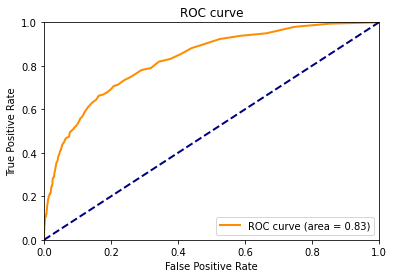

In [41]:
y_pred_prob_rf = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = roc_auc_score(y_test, y_pred_prob_rf)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[2290   61]
 [ 243   95]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2351
           1       0.61      0.28      0.38       338

    accuracy                           0.89      2689
   macro avg       0.76      0.63      0.66      2689
weighted avg       0.87      0.89      0.87      2689



the accuracy rate is 88.69%, which is better than logistics regression.

#### RF-hpermeter turing

In [43]:
n_estimators=[int(x) for x in np.linspace(start=1,stop=1000,num=10)]

turing n_trees

In [44]:
param_grids_rf={'n_estimators':n_estimators}

In [45]:
rf_grid=GridSearchCV(rf,param_grids_rf,cv=6)

In [46]:
rf_grid.fit(X_train,y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.8874940243805275
{'n_estimators': 1000}


Sadly after the hyperparameter truning the accuracy only increased by a little, due to I didn't turn all parameters.

Dealing with imbalance target-Example with lr and SMOTE method

In [47]:
from imblearn.over_sampling import SMOTE


In [54]:
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [61]:
np.bincount(y_train_res)

array([9403, 9403])

In [55]:
lr2=LogisticRegression()

In [57]:
lr2.fit(X_train_res,y_train_res)
y_pred_res=lr2.predict(X_test)

In [60]:
print(confusion_matrix(y_test,y_pred_res))
print(classification_report(y_test,y_pred_res))
accuracy_score(y_test, y_pred_res)


[[1556  795]
 [  96  242]]
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      2351
           1       0.23      0.72      0.35       338

    accuracy                           0.67      2689
   macro avg       0.59      0.69      0.56      2689
weighted avg       0.85      0.67      0.72      2689



0.6686500557828189